In [1]:
## Preloads
using Statistics
using FFTW
using Plots
using BenchmarkTools
using Profile
using LinearAlgebra
using Measures
using HDF5
push!(LOAD_PATH, pwd())
using DHC_2DUtils
using MLDatasets
using Images
theme(:juno)
using DSP
using Interpolations
using Distributed
using ProgressMeter

  likely near /n/home12/saydjari/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl:162
  likely near /n/home12/saydjari/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl:162
  likely near /n/home12/saydjari/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl:166
  likely near /n/home12/saydjari/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl:166
  likely near /n/home12/saydjari/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl:176
  likely near /n/home12/saydjari/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl:179
  likely near /n/home12/saydjari/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl:181
  likely near /n/home12/saydjari/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl:184
  likely near /n/home12/saydjari/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl:186
  likely near /n/home12/saydjari/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl:189
  likely near /n/home12/saydjari/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl:203
  likely near /n/home12/saydjari/.julia/packages/Plots

In [2]:
using Glob
using FITSIO

In [3]:
function imread(file)
    f = FITS(file)
    data = read(f[1])
    close(f)
    data = convert(Array{Float64,2}, data)
    imdown = imresize(data,(512,512))
end

imread (generic function with 1 method)

In [4]:
file_list = sort(glob("*.fits","/n/fink2/dfink/mldust/wssa/"));

In [5]:
temp = imread(file_list[1]);

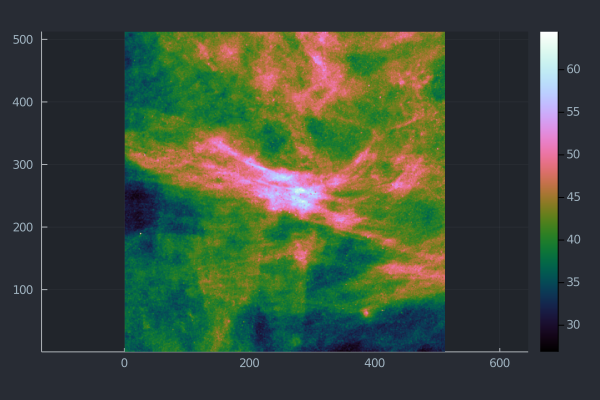

In [6]:
Plots.heatmap(temp, aspectratio=1,c=:cubehelix)

In [7]:
function WISE_process(file)
    pat = r"\d+\d*"
    number = parse(Int64,[match.match for match in eachmatch(pat, file)][2])
    temp = imread(file)
    
    # filter bank
    filter_hash = fink_filter_hash(1,8,nx=256,wd=2)
    
    R = 128
    size_array = 512

    Nx = Int(ceil(size_array/R))
    rx = Int(floor((size_array-2*R)/(Nx-2)))

    minArx = []
    minAry = []
    for r = 0:Nx-2 #row
        for q = 0:Nx-2 #col
            append!(minArx,round(r*rx))
            append!(minAry,round(q*rx))
        end
    end

    for r in 0:Nx-3 #row
        for q in 0:Nx-3 #col
            append!(minArx,round(r*rx+Int(ceil(rx/2))))
            append!(minAry,round(q*rx+Int(ceil(rx/2))))
        end
    end
    
    minAry[minAry.==0] .= 1
    minArx[minArx.==0] .= 1
    
    coeff = zeros(size(minArx)[1],2452)
    labels = zeros(size(minArx)[1],3)
    
    i=1
    for (sp1,sp2) in zip(minArx,minAry)
        temp2d = temp[sp1:sp1+256,sp2:sp2+256]
                        
        coeff[i,:].= DHC_compute(temp2d, filter_hash, filter_hash)
        labels[i,1]=number
        labels[i,2]=sp1
        labels[i,3]=sp2
        i+=1
    end
    return coeff,labels
end

WISE_process (generic function with 1 method)

In [8]:
addprocs(30);

In [9]:
@everywhere begin
    using Statistics
    using BenchmarkTools
    using LinearAlgebra
    using Distributed
    using ProgressMeter
    push!(LOAD_PATH, pwd())
    using DHC_2DUtils
    using FFTW
    using MLDatasets
    using Images
    using Interpolations
    using FITSIO
    
    pat = r"\d+\d*"
    
    R = 128
    size_array = 512

    Nx = Int(ceil(size_array/R))
    rx = Int(floor((size_array-2*R)/(Nx-2)))

    minArx = []
    minAry = []
    for r = 0:Nx-2 #row
        for q = 0:Nx-2 #col
            append!(minArx,round(r*rx))
            append!(minAry,round(q*rx))
        end
    end

    for r in 0:Nx-3 #row
        for q in 0:Nx-3 #col
            append!(minArx,round(r*rx+Int(ceil(rx/2))))
            append!(minAry,round(q*rx+Int(ceil(rx/2))))
        end
    end

    minAry[minAry.==0] .= 1
    minArx[minArx.==0] .= 1
    
    numsubim = size(minArx)[1]
    
    # filter bank
    filter_hash = fink_filter_hash(1,8,nx=256,wd=2)
    
    function imread(file)
        f = FITS(file)
        data = read(f[1])
        close(f)
        data = convert(Array{Float64,2}, data)
        imdown = imresize(data,(512,512))
    end
    
    function WISE_DHC(file)
        
        number = parse(Int64,[match.match for match in eachmatch(pat, file)][2])
        temp = imread(file)

        coeff = zeros(numsubim,2452)
        labels = zeros(numsubim,3)

        i=1
        for (sp1,sp2) in zip(minArx,minAry)
            temp2d = temp[sp1:sp1+256,sp2:sp2+256]

            coeff[i,:].= DHC_compute(temp2d, filter_hash, filter_hash)
            labels[i,1]=number
            labels[i,2]=sp1
            labels[i,3]=sp2
            i+=1
        end
        return coeff,labels
    end
    
end

WISE_DHC_out = @showprogress pmap(WISE_DHC,file_list)
coeff = getindex.(WISE_DHC_out, 1);
labels = getindex.(WISE_DHC_out, 2);

labels_out = vcat(labels...)
coeff_out = vcat(coeff...)

filename = "WISE_DHC.h5"
h5write(filename, "main/coeff", coeff_out)
h5write(filename, "main/labels", labels_out)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


277-element Array{Tuple{Array{Float64,2},Array{Float64,2}},1}:
 ([38.76841831186339 15.189420693014846 … 0.02761307796326121 0.17121208525377027; 40.48351832396632 24.942066025201157 … 0.00595073008188214 0.17406406082706227; … ; 43.88649779562062 24.449861828145032 … 0.006935859535489724 0.23507788310557529; 44.924739120625595 16.995671276822826 … 0.003684346390492136 0.21275857062148446], [0.0 1.0 1.0; 0.0 1.0 128.0; … ; 0.0 192.0 64.0; 0.0 192.0 192.0])           
 ([28.137120750143925 23.05347581193839 … 0.011075360406342747 0.18195257433278436; 31.90239885921516 49.03672920231594 … 0.009742034948404707 0.1893029060378413; … ; 39.726068176788814 60.40258083685735 … 0.007257002423875518 0.3111625570285116; 38.54963009160614 51.93932059970311 … 0.006372855884087606 0.2775040634988305], [1.0 1.0 1.0; 1.0 1.0 128.0; … ; 1.0 192.0 64.0; 1.0 192.0 192.0])               
 ([28.477973314516966 13.589742703638978 … 0.007699640419609661 0.18879471125220276; 30.524122550104202 15.649478828116

In [21]:
function wind_2d(nx)
    dx   = nx/2-1
    filter = zeros(Float64, nx, nx)
    A = DSP.tukey(nx, 0.3)
    itp = extrapolate(interpolate(A,BSpline(Linear())),0)
    @inbounds for x = 1:nx
        sx = x-dx-1    # define sx,sy so that no fftshift() needed
        for y = 1:nx
            sy = y-dx-1
            r  = sqrt.((sx).^2 + (sy).^2) + 128
            filter[x,y] = itp(r)
        end
    end
    return filter
end

wind_2d (generic function with 1 method)

In [22]:
mean(temp)

41.48977801642832

In [27]:
@everywhere begin
    using Statistics
    using BenchmarkTools
    using LinearAlgebra
    using Distributed
    using ProgressMeter
    push!(LOAD_PATH, pwd())
    using DHC_2DUtils
    using FFTW
    using MLDatasets
    using Images
    using Interpolations
    using FITSIO
    using DSP
    
    pat = r"\d+\d*"
    
    R = 128
    size_array = 512
    im_size = 256-1

    Nx = Int(ceil(size_array/R))
    rx = Int(floor((size_array-2*R)/(Nx-2)))

    minArx = []
    minAry = []
    for r = 0:Nx-2 #row
        for q = 0:Nx-2 #col
            append!(minArx,round(r*rx))
            append!(minAry,round(q*rx))
        end
    end

    for r in 0:Nx-3 #row
        for q in 0:Nx-3 #col
            append!(minArx,round(r*rx+Int(ceil(rx/2))))
            append!(minAry,round(q*rx+Int(ceil(rx/2))))
        end
    end

    minAry.+= 1
    minArx.+= 1
    
    numsubim = size(minArx)[1]
    
    # filter bank
    filter_hash = fink_filter_hash(1,8,nx=256,wd=2)
    
    function imread(file)
        f = FITS(file)
        data = read(f[1])
        close(f)
        data = convert(Array{Float64,2}, data)
        imdown = imresize(data,(512,512))
    end
    
    function wind_2d(nx)
        dx   = nx/2-1
        filter = zeros(Float64, nx, nx)
        A = DSP.tukey(nx, 0.3)
        itp = extrapolate(interpolate(A,BSpline(Linear())),0)
        @inbounds for x = 1:nx
            sx = x-dx-1    # define sx,sy so that no fftshift() needed
            for y = 1:nx
                sy = y-dx-1
                r  = sqrt.((sx).^2 + (sy).^2) + nx/2
                filter[x,y] = itp(r)
            end
        end
        return filter
    end

    function WISE_DHC(file)
        
        number = parse(Int64,[match.match for match in eachmatch(pat, file)][2])
        temp = imread(file)

        coeff = zeros(numsubim,2452)
        labels = zeros(numsubim,3)

        i=1
        for (sp1,sp2) in zip(minArx,minAry)
            temp2d = temp[sp1:sp1+im_size,sp2:sp2+im_size]
            meanVal = mean(temp2d)
            temp2d_a = (temp2d.-meanVal).*wind_2d(256).+meanVal

            coeff[i,:].= DHC_compute(temp2d_a, filter_hash, filter_hash)
            labels[i,1]=number
            labels[i,2]=sp1
            labels[i,3]=sp2
            i+=1
        end
        return coeff,labels
    end
    
end

WISE_DHC_out = @showprogress pmap(WISE_DHC,file_list)
coeff = getindex.(WISE_DHC_out, 1);
labels = getindex.(WISE_DHC_out, 2);

labels_out = vcat(labels...)
coeff_out = vcat(coeff...)

filename = "WISE_DHC_a.h5"
h5write(filename, "main/coeff", coeff_out)
h5write(filename, "main/labels", labels_out)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


In [28]:
@everywhere begin
    using Statistics
    using BenchmarkTools
    using LinearAlgebra
    using Distributed
    using ProgressMeter
    push!(LOAD_PATH, pwd())
    using DHC_2DUtils
    using FFTW
    using MLDatasets
    using Images
    using Interpolations
    using FITSIO
    using DSP
    
    pat = r"\d+\d*"
    
    R = 128
    size_array = 512
    im_size = 256-1

    Nx = Int(ceil(size_array/R))
    rx = Int(floor((size_array-2*R)/(Nx-2)))

    minArx = []
    minAry = []
    for r = 0:Nx-2 #row
        for q = 0:Nx-2 #col
            append!(minArx,round(r*rx))
            append!(minAry,round(q*rx))
        end
    end

    for r in 0:Nx-3 #row
        for q in 0:Nx-3 #col
            append!(minArx,round(r*rx+Int(ceil(rx/2))))
            append!(minAry,round(q*rx+Int(ceil(rx/2))))
        end
    end

    minAry.+= 1
    minArx.+= 1
    
    numsubim = size(minArx)[1]
    
    # filter bank
    filter_hash = fink_filter_hash(1,8,nx=256,wd=2)
    
    function imread(file)
        f = FITS(file)
        data = read(f[1])
        close(f)
        data = convert(Array{Float64,2}, data)
        imdown = imresize(data,(512,512))
    end
    
    function wind_2d(nx)
        dx   = nx/2-1
        filter = zeros(Float64, nx, nx)
        A = DSP.tukey(nx, 0.3)
        itp = extrapolate(interpolate(A,BSpline(Linear())),0)
        @inbounds for x = 1:nx
            sx = x-dx-1    # define sx,sy so that no fftshift() needed
            for y = 1:nx
                sy = y-dx-1
                r  = sqrt.((sx).^2 + (sy).^2) + nx/2
                filter[x,y] = itp(r)
            end
        end
        return filter
    end

    function WISE_DHC(file)
        
        number = parse(Int64,[match.match for match in eachmatch(pat, file)][2])
        temp = imread(file)

        coeff = zeros(numsubim,2452)
        labels = zeros(numsubim,3)

        i=1
        for (sp1,sp2) in zip(minArx,minAry)
            temp2d = temp[sp1:sp1+im_size,sp2:sp2+im_size]
            #meanVal = mean(temp2d)
            #temp2d_a = (temp2d.-meanVal).*wind_2d(256).+meanVal

            coeff[i,:].= DHC_compute(temp2d, filter_hash, filter_hash)
            labels[i,1]=number
            labels[i,2]=sp1
            labels[i,3]=sp2
            i+=1
        end
        return coeff,labels
    end
    
end

WISE_DHC_out = @showprogress pmap(WISE_DHC,file_list)
coeff = getindex.(WISE_DHC_out, 1);
labels = getindex.(WISE_DHC_out, 2);

labels_out = vcat(labels...)
coeff_out = vcat(coeff...)

filename = "WISE_DHC.h5"
h5write(filename, "main/coeff", coeff_out)
h5write(filename, "main/labels", labels_out)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


In [33]:
file_list = sort(glob("*.fits.gz","/n/fink2/www/ameisner/wssa/v1.0"));

In [34]:
file_list

430-element Array{String,1}:
 "/n/fink2/www/ameisner/wssa/v1.0/wise_001.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/wise_002.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/wise_003.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/wise_004.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/wise_005.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/wise_006.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/wise_007.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/wise_008.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/wise_009.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/wise_010.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/wise_011.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/wise_012.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/wise_013.fits.gz"
 ⋮                                                 
 "/n/fink2/www/ameisner/wssa/v1.0/wise_419.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/wise_420.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/wise_421.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/wise_422.fits.gz"
 "/n/fink2/www/ameisner/wssa/v1.0/w

In [40]:
function imread(file)
    f = FITS(file)
    data = read(f[1])
    close(f)
    data = convert(Array{Float64,2}, data)
    imdown = imresize(data,(4000,4000))
end

imread (generic function with 1 method)

In [41]:
temp = imread(file_list[1]);

In [42]:
@everywhere begin
    using Statistics
    using BenchmarkTools
    using LinearAlgebra
    using Distributed
    using ProgressMeter
    push!(LOAD_PATH, pwd())
    using DHC_2DUtils
    using FFTW
    using MLDatasets
    using Images
    using Interpolations
    using FITSIO
    using DSP
    
    pat = r"\d+\d*"
    
    R = 128
    size_array = 4000
    im_size = 256-1

    Nx = Int(ceil(size_array/R))
    rx = Int(floor((size_array-2*R)/(Nx-2)))

    minArx = []
    minAry = []
    for r = 0:Nx-2 #row
        for q = 0:Nx-2 #col
            append!(minArx,round(r*rx))
            append!(minAry,round(q*rx))
        end
    end

    for r in 0:Nx-3 #row
        for q in 0:Nx-3 #col
            append!(minArx,round(r*rx+Int(ceil(rx/2))))
            append!(minAry,round(q*rx+Int(ceil(rx/2))))
        end
    end

    minAry.+= 1
    minArx.+= 1
    
    numsubim = size(minArx)[1]
    
    # filter bank
    filter_hash = fink_filter_hash(1,8,nx=256,wd=2)
    
    function imread(file)
        f = FITS(file)
        data = read(f[1])
        close(f)
        data = convert(Array{Float64,2}, data)
        imdown = imresize(data,(4000,4000))
    end
    
    function wind_2d(nx)
        dx   = nx/2-1
        filter = zeros(Float64, nx, nx)
        A = DSP.tukey(nx, 0.3)
        itp = extrapolate(interpolate(A,BSpline(Linear())),0)
        @inbounds for x = 1:nx
            sx = x-dx-1    # define sx,sy so that no fftshift() needed
            for y = 1:nx
                sy = y-dx-1
                r  = sqrt.((sx).^2 + (sy).^2) + nx/2
                filter[x,y] = itp(r)
            end
        end
        return filter
    end

    function WISE_DHC(file)
        
        number = parse(Int64,[match.match for match in eachmatch(pat, file)][2])
        temp = imread(file)

        coeff = zeros(numsubim,2452)
        labels = zeros(numsubim,3)

        i=1
        for (sp1,sp2) in zip(minArx,minAry)
            temp2d = temp[sp1:sp1+im_size,sp2:sp2+im_size]
            meanVal = mean(temp2d)
            temp2d_a = (temp2d.-meanVal).*wind_2d(256).+meanVal

            coeff[i,:].= DHC_compute(temp2d_a, filter_hash, filter_hash)
            labels[i,1]=number
            labels[i,2]=sp1
            labels[i,3]=sp2
            i+=1
        end
        return coeff,labels
    end
    
end

WISE_DHC_out = @showprogress pmap(WISE_DHC,file_list)
coeff = getindex.(WISE_DHC_out, 1);
labels = getindex.(WISE_DHC_out, 2);

labels_out = vcat(labels...)
coeff_out = vcat(coeff...)

filename = "WISE_DHC_unclean_a.h5"
h5write(filename, "main/coeff", coeff_out)
h5write(filename, "main/labels", labels_out)

Progress: 100%|█████████████████████████████████████████| Time: 2:23:46


In [43]:
@everywhere begin
    using Statistics
    using BenchmarkTools
    using LinearAlgebra
    using Distributed
    using ProgressMeter
    push!(LOAD_PATH, pwd())
    using DHC_2DUtils
    using FFTW
    using MLDatasets
    using Images
    using Interpolations
    using FITSIO
    using DSP
    
    pat = r"\d+\d*"
    
    R = 128
    size_array = 4000
    im_size = 256-1

    Nx = Int(ceil(size_array/R))
    rx = Int(floor((size_array-2*R)/(Nx-2)))

    minArx = []
    minAry = []
    for r = 0:Nx-2 #row
        for q = 0:Nx-2 #col
            append!(minArx,round(r*rx))
            append!(minAry,round(q*rx))
        end
    end

    for r in 0:Nx-3 #row
        for q in 0:Nx-3 #col
            append!(minArx,round(r*rx+Int(ceil(rx/2))))
            append!(minAry,round(q*rx+Int(ceil(rx/2))))
        end
    end

    minAry.+= 1
    minArx.+= 1
    
    numsubim = size(minArx)[1]
    
    # filter bank
    filter_hash = fink_filter_hash(1,8,nx=256,wd=2)
    
    function imread(file)
        f = FITS(file)
        data = read(f[1])
        close(f)
        data = convert(Array{Float64,2}, data)
        imdown = imresize(data,(4000,4000))
    end
    
    function wind_2d(nx)
        dx   = nx/2-1
        filter = zeros(Float64, nx, nx)
        A = DSP.tukey(nx, 0.3)
        itp = extrapolate(interpolate(A,BSpline(Linear())),0)
        @inbounds for x = 1:nx
            sx = x-dx-1    # define sx,sy so that no fftshift() needed
            for y = 1:nx
                sy = y-dx-1
                r  = sqrt.((sx).^2 + (sy).^2) + nx/2
                filter[x,y] = itp(r)
            end
        end
        return filter
    end

    function WISE_DHC(file)
        
        number = parse(Int64,[match.match for match in eachmatch(pat, file)][2])
        temp = imread(file)

        coeff = zeros(numsubim,2452)
        labels = zeros(numsubim,3)

        i=1
        for (sp1,sp2) in zip(minArx,minAry)
            temp2d = temp[sp1:sp1+im_size,sp2:sp2+im_size]
            #meanVal = mean(temp2d)
            #temp2d_a = (temp2d.-meanVal).*wind_2d(256).+meanVal

            coeff[i,:].= DHC_compute(temp2d, filter_hash, filter_hash)
            labels[i,1]=number
            labels[i,2]=sp1
            labels[i,3]=sp2
            i+=1
        end
        return coeff,labels
    end
    
end

WISE_DHC_out = @showprogress pmap(WISE_DHC,file_list)
coeff = getindex.(WISE_DHC_out, 1);
labels = getindex.(WISE_DHC_out, 2);

labels_out = vcat(labels...)
coeff_out = vcat(coeff...)

filename = "WISE_DHC_unclean.h5"
h5write(filename, "main/coeff", coeff_out)
h5write(filename, "main/labels", labels_out)

Progress: 100%|█████████████████████████████████████████| Time: 2:22:56


In [44]:
numsubim

1861

In [46]:
size(coeff_out)

(800230, 2452)